In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import ast
from tqdm import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

In [2]:
rawdata = pd.read_csv('HDFS.csv')

In [3]:
raw_templates = pd.read_csv('HDFS_templates.csv')
raw_anomalies = pd.read_csv('anomaly_label.csv')
every_EventId = {}
for i in range(0, len(raw_templates)):
    every_EventId[raw_templates.iloc[i][0]] = i+1

In [4]:
filtered_data = rawdata[['LineId', 'EventId', 'ParameterList']] #Kivesszük az értelmetlen infókat

In [5]:
anomalies = set()
helyes_eredmeny = {} # 0, ha Normál, 1, ha Anomália
for i in tqdm(range(0,len(raw_anomalies))):
    raw_ParamterList = raw_anomalies.iloc[i][0] # Kiválasztjuk a Paraméterlistát
    block_anom = raw_ParamterList
    first_occurrence = raw_ParamterList.find("blk_") + 4 # Megtaláljuk a blk_-t és hozzáadtunk 4-et, mert lk_ és utána kezdődjön
    block_azon_string = raw_ParamterList[first_occurrence: first_occurrence + 10]# megkapjuk a stringet 19 (blockazon_hossza)
    block_azon = int(block_azon_string) # átállunk integerekre
    if(raw_anomalies.iloc[i][1] == "Anomaly"):
        helyes_eredmeny[block_azon] = 1
        anomalies.add(block_azon)
    else:
        helyes_eredmeny[block_azon] = 0

100%|███████████████████████████████████████████████████████████████████████| 575061/575061 [00:28<00:00, 20531.09it/s]


In [6]:
block_Event_dict = {} ##
listank = set()
for i in tqdm(range(0,len(filtered_data))):
    raw_ParamterList = filtered_data.iloc[i][2] # Kiválasztjuk a Paraméterlistát
    first_occurrence = raw_ParamterList.find("blk_") + 4 # Megtaláljuk a blk_-t és hozzáadtunk 4-et, mert lk_ és utána kezdődjön
    block_azon_string = raw_ParamterList[first_occurrence: first_occurrence + 10]# megkapjuk a stringet 19 (blockazon_hossza)
    block_azon = int(block_azon_string) # átállunk integerekre
    if block_azon not in listank: # Ha nincs benne eddig már ez a blockazonosító
        listank.add(block_azon) # Adjuk hozzá a halmazhoz
        block_Event_dict[block_azon] = [every_EventId.get(filtered_data.iloc[i][1])] # Hozzuk létre a dict-ben a kulcs-értéktömb párt
        
    else: # Ha benne van,
        block_Event_dict.get(block_azon).append(every_EventId.get(filtered_data.iloc[i][1])) # akkor adjuk hozzá a megfelelő értéktömbhöz az elemet
with open('block_Event_dict.txt', 'w') as f:
     f.write(json.dumps(block_Event_dict))

100%|████████████████████████████████████████████████████████████████████| 11175629/11175629 [18:56<00:00, 9834.30it/s]


In [7]:
block_Event_dict = {}
with open('block_Event_dict.txt', 'r') as ff:
    contents = ff.read()
    dictionary = ast.literal_eval(contents)
    block_Event_dict = dictionary
block_Event_dict

{'-160899968': [1,
  2,
  1,
  1,
  3,
  3,
  4,
  4,
  3,
  4,
  5,
  5,
  5,
  6,
  1,
  7,
  6,
  1,
  8,
  9,
  5,
  5,
  10,
  9,
  6,
  6,
  1,
  1,
  7,
  8,
  5,
  5,
  1,
  6,
  1,
  7,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  8,
  9,
  6,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  5,
  5,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  11,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  12,
  6,
  1,
  10,
  10,
  10,
  10,
  10,
  7,
  10,
  10,
  10,
  10,
  5,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10

In [7]:
import random
data_training = {}
data_test = {}
data_validation = {}
lista = list(block_Event_dict.keys())

random.shuffle(lista)

for i in tqdm(range(len(lista)//2)):
    data_training[lista[i]] = list(block_Event_dict.get(lista[i]))

for i in tqdm(range(len(lista)//2, (len(lista)//2 + len(lista)//4))):
    data_validation[lista[i]] = list(block_Event_dict.get(lista[i]))
    
    
for i in tqdm(range((len(lista)//2 + len(lista)//4), len(lista))):
    data_test[lista[i]] = list(block_Event_dict.get(lista[i]))
    

#data_training = dict(list(block_Event_dict.items())[0: len(lista)//3])
#data_validation = dict(list(block_Event_dict.items())[len(lista)//3: 2*len(lista)//3])
#data_test = dict(list(block_Event_dict.items())[2*len(lista)//3: len(lista)])
#helyes_validation_eredmeny = helyes_eredmeny[len(lista)//3: 2*len(lista)//3]

with open('data_training.txt', 'w') as g:
     g.write(json.dumps(data_training))
with open('data_validation.txt', 'w') as gg:
       gg.write(json.dumps(data_validation))
with open('data_test.txt', 'w') as ggg:
     ggg.write(json.dumps(data_test))

100%|██████████████████████████████████████████████████████████████████████| 143751/143751 [00:00<00:00, 285774.13it/s]


In [9]:
len(data_training)

287500

In [10]:
len(data_validation)

143750

In [11]:
len(data_test)

143751

In [12]:
len(data_training) + len(data_validation) + len(data_test)

575001

In [13]:
with open('data_training.txt', 'r') as f:
    contents = f.read()
    lista = ast.literal_eval(contents)
    data_training = lista
    f.close()
with open('data_validation.txt', 'r') as ff:
    contents = ff.read()
    listb = ast.literal_eval(contents)
    data_validation = listb
    ff.close()
with open('data_test.txt', 'r') as fff:
    contents = fff.read()
    listy = ast.literal_eval(contents)
    data_test = listy
    fff.close()

In [8]:
##scaler = MinMaxScaler()
##training_data = scaler.fit_transform(training_data)
X_train = []
y_train = []
train_blocks = []

list_temp = [] 

maxlen = 0
MaxWindow = 50

keys = list(data_training.keys())
values = list(data_training.values())

for i in tqdm(range(0, len(data_training.keys()))):
    if int(keys[i]) in anomalies:
        continue
    first_value = values[i] #Adott kulcsokhoz tartozó tömb
    if len(first_value) < MaxWindow: ## Ha kisebb mint a MaxWindow
        list_of_zeros = [0] * (MaxWindow - len(first_value)) # Zérusokat tartalmazó
        X_to_append = [len(every_EventId.keys()) + 1] + first_value + list_of_zeros # [49,1,1,1,2,3,0,0,0,0,0,0,0]
        X_train.append(X_to_append)
        
        Y_to_append = list(np.array(first_value, dtype="float")-1)
        Y_to_append.append(len(every_EventId.keys())) # END jel a végén
        Y_to_append += list_of_zeros
        y_train.append(Y_to_append)
    train_blocks.append(int(keys[i]))         
        
#with open('X_train.txt', 'w') as g:
#     g.write(json.dumps(X_train))
#with open('y_train.txt', 'w') as gg:
#       gg.write(json.dumps(y_train))

100%|███████████████████████████████████████████████████████████████████████| 287500/287500 [00:03<00:00, 94628.33it/s]


In [10]:
len(X_train)

279027

In [36]:
for i in train_blocks:
    if i in anomalies:
        print("IGEN")

In [44]:
len(train_blocks)

279164

In [82]:
values = list(data_test.values())
values

[[1, 2, 1, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5, 32, 32, 32, 17, 17, 17],
 [1, 1, 2, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5, 13, 32, 32, 32, 17, 17, 17],
 [2,
  1,
  1,
  1,
  5,
  3,
  4,
  3,
  4,
  5,
  5,
  3,
  4,
  10,
  10,
  35,
  10,
  35,
  10,
  10,
  10,
  35,
  10,
  10,
  35,
  32,
  32,
  32,
  17,
  17,
  17],
 [2,
  1,
  1,
  1,
  3,
  4,
  3,
  4,
  5,
  5,
  3,
  4,
  5,
  35,
  35,
  10,
  13,
  32,
  32,
  32,
  17,
  17,
  17],
 [2, 1, 1, 1, 5, 5, 5, 3, 4, 3, 4, 3, 4, 13, 32, 32, 32, 17, 17, 17],
 [1, 2, 1, 1, 3, 4, 3, 4, 5, 5, 5, 3, 4, 35, 35, 10, 32, 32, 32, 17, 17, 17],
 [1, 1, 2, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5, 32, 32, 32, 17, 17, 17],
 [1, 2, 1, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5, 32, 32, 32, 17, 17, 17],
 [1, 2, 1, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5],
 [1,
  1,
  1,
  2,
  3,
  4,
  3,
  4,
  3,
  4,
  5,
  5,
  5,
  11,
  12,
  1,
  7,
  6,
  5,
  5,
  17,
  11,
  12,
  1,
  6,
  7,
  5,
  5,
  17,
  11,
  12,
  1,
  7,
  6,
  5,
  5,
  17],
 [2,
  1,
  1,
  1,
  5,
  5,
  5,
  3,
  4,
  

In [9]:
##scaler = MinMaxScaler()
##training_data = scaler.fit_transform(training_data)
X_anomaly_test = []
y_anomaly_test = []
anom_blocks = []

list_temp = [] 
maxlen = 0
MaxWindow = 50

values = list(data_test.values())

for i in tqdm(range(0, len(data_test.keys()))):
    if int(keys[i]) not in anomalies:
        continue
    first_value = values[i] #Adott kulcsokhoz tartozó tömb
    print(first_value)
    if len(first_value) < MaxWindow: ## Ha kisebb mint a MaxWindow
        list_of_zeros = [0] * (MaxWindow - len(first_value)) # Zérusokat tartalmazó
        X_to_append = [len(every_EventId.keys()) + 1] + first_value + list_of_zeros # [49,1,1,1,2,3,0,0,0,0,0,0,0]
        X_anomaly_test.append(X_to_append)
        
        
        Y_to_append = list(np.array(first_value, dtype="float")-1)
        Y_to_append.append(len(every_EventId.keys())) # END jel a végén
        Y_to_append += list_of_zeros
        y_anomaly_test.append(Y_to_append)
    else:
        helyes_test_eredmeny.pop(i)
    anom_blocks.append(int(keys[i]))    
    
with open('anom_blocks.txt', 'w') as g:
     g.write(json.dumps(anom_blocks))
with open('y_anomaly_test.txt', 'w') as gg:
     gg.write(json.dumps(y_anomaly_test))

100%|█████████████████████████████████████████████████████████████████████| 143751/143751 [00:00<00:00, 1111895.60it/s]

[2, 1, 1, 1, 5, 5, 5, 3, 4, 3, 4, 3, 4, 13, 35, 10, 35, 32, 32, 32, 17, 17, 17]
[1, 1, 1, 2, 3, 4, 3, 4, 3, 4, 5, 5, 5, 32, 32, 32, 17, 17, 17]
[2, 1, 1, 1, 5, 5, 5, 3, 4, 3, 3, 4, 4, 10, 10, 35, 10, 35, 10, 10, 10, 35, 10, 35, 10, 32, 32, 32, 17, 17, 17]
[1, 2, 1, 1, 3, 4, 3, 4, 5, 5, 5, 3, 4, 32, 32, 32, 17, 17, 17]
[1, 1, 1, 2, 3, 4, 3, 4, 3, 4, 5, 5, 5, 32, 32, 32, 17, 17, 17]
[1, 2, 1, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5]
[1, 1, 2, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5]
[1, 1, 2, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5, 32, 32, 32, 17, 17, 17]
[1, 1, 2, 1, 3, 4, 3, 4, 5, 5, 3, 4, 5, 32, 32, 32, 17, 17, 17]
[1, 2, 1, 1, 3, 4, 3, 4, 5, 5, 5, 3, 4, 35, 10, 11, 12, 1, 6, 7, 5, 5, 17, 11, 12, 1, 6, 7, 5, 5, 17, 35, 32, 32, 32, 17, 17, 17]
[1, 1, 1, 2, 3, 4, 3, 4, 5, 5, 3, 4, 5, 32, 32, 32, 17, 17, 17]
[1, 1, 2, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5]
[1, 2, 1, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5, 32, 32, 32, 17, 17, 17]
[1, 1, 1, 2, 3, 4, 3, 4, 3, 4, 5, 5, 5]
[1, 1, 1, 2, 3, 4, 3, 4, 3, 4, 5, 5, 5, 13, 32, 32, 32, 17, 17, 17]
[1

In [11]:
len(X_anomaly_test)

4233

In [88]:
anom_blocks

[5051612593, -464147823]

In [85]:
for i in anom_blocks:
    if i not in anomalies:
        print("IGEN")

In [87]:
cnt = 0
for t in tqdm(train_blocks[0:500]):
    for a in anom_blocks:
        if block_Event_dict[t] == block_Event_dict[a]:
            cnt += 1
            break
    print(block_Event_dict[a])
print(cnt)

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 50004.82it/s]

[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]

In [55]:
cnt = 0
for t in tqdm(X_train[0:5]):
    for a in X_anomaly_test:
        if t == a:
            cnt += 1
            print(t)
            break
        
print(cnt)

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5000.36it/s]

[49, 2, 1, 1, 1, 3, 4, 3, 4, 5, 5, 3, 4, 5, 32, 32, 32, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[49, 1, 1, 1, 2, 3, 4, 3, 4, 3, 4, 5, 5, 5, 13, 10, 10, 35, 10, 10, 35, 32, 32, 32, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[49, 1, 2, 1, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3


In [70]:
for t in X_anomaly_test[0:5]:
    print(t)

[49, 1, 1, 2, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5, 32, 32, 32, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[49, 1, 1, 1, 2, 3, 4, 3, 4, 3, 4, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[49, 1, 1, 2, 1, 3, 4, 3, 4, 3, 4, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[49, 1, 1, 2, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[49, 2, 1, 1, 1, 5, 5, 5, 3, 4, 3, 4, 3, 4, 13, 35, 35, 10, 13, 13, 32, 32, 32, 17, 17, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [69]:
for t in anom_blocks[0:5]:
    print(block_Event_dict[t])

[2, 1]
[2, 1]
[2, 1, 1, 16]
[2, 1]
[1, 1, 2, 16]


In [ ]:
X_train = []
y_train = []
data_training = {}
data_test = {}
data_validation = {}

with open('X_train.txt', 'r') as f:
    contents = f.read()
    listx = ast.literal_eval(contents)
    X_train = listx
    f.close()
with open('y_train.txt', 'r') as ff:
    contents = ff.read()
    listy = ast.literal_eval(contents)
    y_train = listy
    ff.close()

In [ ]:
X_train, y_train = np.array(X_train, dtype="int16"), np.array(y_train, dtype="int16")

In [13]:
len(X_train)

279027

In [13]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [14]:
regressior = Sequential()

from tensorflow.keras.layers import TimeDistributed

regressior.add(tf.keras.layers.Input(shape = (51,)))
regressior.add(tf.keras.layers.Embedding(50,100, mask_zero = True))
regressior.add(LSTM(units = 50, return_sequences = True, dropout=0.1))
regressior.add(LSTM(units = 100, return_sequences = True, dropout=0.1))
regressior.add(TimeDistributed(Dense(units = 49, activation = 'softmax')))

In [15]:
regressior.compile(optimizer = 'adam',  loss='sparse_categorical_crossentropy')

In [16]:
regressior.fit(X_train, y_train, epochs = 20, batch_size = 128, shuffle = True)

Epoch 1/20
2180/2180 [==============================] - 59s 22ms/step - loss: 0.1690
Epoch 2/20
2180/2180 [==============================] - 48s 22ms/step - loss: 0.0989
Epoch 3/20
2180/2180 [==============================] - 48s 22ms/step - loss: 0.0965
Epoch 4/20
2180/2180 [==============================] - 48s 22ms/step - loss: 0.0956
Epoch 5/20
2180/2180 [==============================] - 48s 22ms/step - loss: 0.0952
Epoch 6/20
2180/2180 [==============================] - 47s 22ms/step - loss: 0.0949
Epoch 7/20
2180/2180 [==============================] - 47s 22ms/step - loss: 0.0947
Epoch 8/20
2180/2180 [==============================] - 48s 22ms/step - loss: 0.0946
Epoch 9/20
2180/2180 [==============================] - 47s 22ms/step - loss: 0.0945
Epoch 10/20
2180/2180 [==============================] - 47s 22ms/step - loss: 0.0944
Epoch 11/20
2180/2180 [==============================] - 47s 22ms/step - loss: 0.0943
Epoch 12/20
2180/2180 [==============================] - 47s 21

In [17]:
keylista = list(data_validation.keys())
keylista
helyes_validation_eredmeny2 = []
for i in keylista:
    a = helyes_eredmeny[int(i)]
    helyes_validation_eredmeny2.append(a)
   # print(helyes_eredmeny.get(i))

ASDAsaddsa

In [18]:
##scaler = MinMaxScaler()
##training_data = scaler.fit_transform(training_data)
X_validation = []
y_validation = []

list_temp = [] 
maxlen = 0
MaxWindow = 50

values = list(data_validation.values())

for i in tqdm(range(0, len(data_validation.keys()))):
    first_value = values[i] #Adott kulcsokhoz tartozó tömb
    if len(first_value) < MaxWindow: ## Ha kisebb mint a MaxWindow
        list_of_zeros = [0] * (MaxWindow - len(first_value)) # Zérusokat tartalmazó
        X_to_append = [len(every_EventId.keys()) + 1] + first_value + list_of_zeros # [49,1,1,1,2,3,0,0,0,0,0,0,0]
        X_validation.append(X_to_append)
        
        Y_to_append = list(np.array(first_value, dtype="float")-1)
        Y_to_append.append(len(every_EventId.keys())) # END jel a végén
        Y_to_append += list_of_zeros
        y_validation.append(Y_to_append)
    else:
        helyes_validation_eredmeny2.pop(i)

with open('X_validate.txt', 'w') as g:
     g.write(json.dumps(X_validation))
with open('y_validate.txt', 'w') as gg:
     gg.write(json.dumps(y_validation))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143750/143750 [00:01<00:00, 92622.48it/s]


In [20]:
X_validation

[[49,
  2,
  1,
  1,
  1,
  3,
  4,
  3,
  4,
  3,
  4,
  5,
  5,
  5,
  32,
  32,
  32,
  17,
  17,
  17,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [49,
  2,
  1,
  1,
  1,
  5,
  5,
  5,
  3,
  4,
  3,
  4,
  3,
  4,
  10,
  10,
  35,
  10,
  35,
  10,
  10,
  35,
  10,
  32,
  32,
  32,
  17,
  17,
  17,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [49,
  2,
  1,
  1,
  1,
  5,
  5,
  5,
  3,
  4,
  3,
  4,
  3,
  4,
  35,
  10,
  35,
  13,
  13,
  32,
  32,
  32,
  17,
  17,
  17,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [49,
  1,
  1,
  1,
  2,
  3,
  4,
  3,
  4,
  3,
  4,
  5,
  5,
  5,
  32,
  32,
  32,
  17,
  17,
  17,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [ ]:
#first_value = block_Event_dict[str(list(anomalies)[0])].copy()
#y_val = first_value.copy()
#first_value.remove(49)
#first_value = [49] + first_value
#first_value

In [ ]:
#Xval = []
#yval = []
#with open('X_validate.txt', 'r') as f:
#    contents = f.read()
 #   listx = ast.literal_eval(contents)
#    Xval = listx
#    f.close()
##with open('y_validate.txt', 'r') as ff:
#    contents = ff.read()
#    listy = ast.literal_eval(contents)
#    yval = listy
 #   ff.close()

In [19]:
X_val, y_val = np.array(X_validation, dtype="int16"), np.array(y_validation, dtype="int16")

In [20]:
X_val.shape

(143734, 51)

In [ ]:
#for i in range(len(X_train)):
#    if helyes_validation_eredmeny[i] == 1:
#        y_pred = regressior.predict(X_train[i:i+1])
#        break

In [21]:
y_pred = regressior.predict(X_val)

4492/4492 [==============================] - 26s 5ms/step


In [55]:
y_pred

array([[[7.6011664e-01, 2.3976664e-01, 2.0641006e-05, ...,
         4.9511019e-08, 5.8901634e-08, 4.2793863e-06],
        [7.2662669e-01, 2.7206153e-01, 1.2491075e-03, ...,
         3.5852551e-08, 3.5710123e-08, 1.6241465e-06],
        [6.4753407e-01, 3.5214514e-01, 2.8760784e-04, ...,
         3.8093138e-09, 4.7195474e-09, 1.4780219e-06],
        ...,
        [2.8399194e-02, 2.9976364e-02, 2.3781898e-02, ...,
         1.8357147e-02, 1.7915593e-02, 2.6314724e-02],
        [2.8399194e-02, 2.9976364e-02, 2.3781898e-02, ...,
         1.8357147e-02, 1.7915593e-02, 2.6314724e-02],
        [2.8399194e-02, 2.9976364e-02, 2.3781898e-02, ...,
         1.8357147e-02, 1.7915593e-02, 2.6314724e-02]],

       [[7.6011664e-01, 2.3976664e-01, 2.0641006e-05, ...,
         4.9511019e-08, 5.8901634e-08, 4.2793863e-06],
        [7.2662669e-01, 2.7206153e-01, 1.2491075e-03, ...,
         3.5852551e-08, 3.5710123e-08, 1.6241465e-06],
        [6.4753407e-01, 3.5214514e-01, 2.8760784e-04, ...,
         3.809

In [65]:
len(y_pred)

143733

In [77]:
X_val[0]

array([49,  1,  1,  1,  2,  3,  4,  3,  4,  3,  4,  5,  5,  5,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int16)

array([ 1,  0,  0,  0,  4,  4,  2,  3,  2,  3,  4,  2,  3, 34,  9, 34, 12,
       31, 31, 31, 16, 16, 16, 48,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int16)

In [22]:
possib_array = []

for i in tqdm(range(0,len(y_pred))): #belső
    possib_array.append([])
    for j in range(0,len(y_pred[i])):
        if(y_val[i][j] != 0 and y_val[i][j] != 49): # Lehet ki kell venni
            possib_array[i].append(y_pred[i][j][y_val[i][j]])
#possib_array # Valószínűségek listája

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143734/143734 [00:15<00:00, 9480.76it/s]


In [23]:
len(possib_array)

143734

In [24]:
possib_array

[[0.25448528,
  0.3061435,
  0.9974439,
  0.847485,
  0.99705637,
  0.79261607,
  0.9999566,
  0.99963975,
  0.9998685,
  0.9985845,
  0.5879683,
  0.9999851,
  0.99999523,
  0.9995943,
  0.9999697,
  0.9999813,
  0.9999229],
 [0.25448528,
  0.68351585,
  0.8942852,
  0.8148306,
  0.9966821,
  0.9942806,
  0.9951497,
  0.9940848,
  0.995861,
  0.99994874,
  0.2903913,
  0.58520097,
  0.9001447,
  0.91738313,
  0.33762017,
  0.999706,
  0.9038799,
  0.46520773,
  0.9993457,
  0.48717564,
  0.9999769,
  0.99999154,
  0.99993837,
  0.9999646,
  0.99996126,
  0.99977964],
 [0.25448528,
  0.68351585,
  0.8942852,
  0.8148306,
  0.9966821,
  0.9942806,
  0.9951497,
  0.9940848,
  0.995861,
  0.99994874,
  0.24329416,
  0.61014694,
  0.84964734,
  0.56660396,
  0.54075694,
  0.502535,
  0.9999819,
  0.99997735,
  0.99786574,
  0.9998566,
  0.99992836,
  0.99987257],
 [0.99979883,
  0.9691607,
  0.9977951,
  0.9323068,
  0.99745435,
  0.87275183,
  0.9999765,
  0.99995184,
  0.99998593,
  0.99

In [25]:
np.where(helyes_validation_eredmeny2)

(array([    44,     59,    101, ..., 143678, 143720, 143733], dtype=int64),)

In [26]:
def calculate_metrics(predicted, actual):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predicted)):
        if   (predicted[i] == 1) and (actual[i] == 1):
            TP += 1
        elif (predicted[i] == 1) and (actual[i] == 0):
            FP += 1
        elif (predicted[i] == 0) and (actual[i] == 0):
            TN += 1
        else:
            FN += 1
            
    if (TP + FP) == 0:
        precision = 0
    else:
        precision = (TP) / (TP + FP)
        
        
    if (TP + FN) == 0:
        recall    = 0
    else:
        recall    = (TP) / (TP + FN)
        
        
    if (TP + FP + TN + FN) == 0:
        accuracy  = 0
    else:
        accuracy  = (TP + TN) / (TP + FP + TN + FN)
        
        
    if(precision + recall == 0):
        f1_score  = 0
    else:
        f1_score  = (2 * precision * recall) / (precision + recall)
        
    
    return accuracy, precision, recall, f1_score

In [ ]:
#proba_eredmeny = []
#soranomalia = 0
#for i in possib_array:
 #   for j in i:
 #       if j < treshold:
 #           soranomalia += 1
 #   if(soranomalia > 0):
 #       proba_eredmeny.append(1)
  #      soranomalia = 0
  #  else:
  #      proba_eredmeny.append(0)

In [27]:
def a_simple_classifier(x, thres = 0.5):
    predicted = []
    soranomalia = 0
    for i in x:
        for j in i:
            if j < thres:
                soranomalia += 1
        if(soranomalia > 0):
            predicted.append(1)
            soranomalia = 0
        else:
            predicted.append(0)
    return predicted

In [ ]:
print(len(helyes_validation_eredmeny2))
prediction = a_simple_classifier(possib_array, 0.001)
print(len(possib_array))

In [54]:
#thresh = np.linspace(0, 0.02,40) 
thresh = np.linspace(0.00002,0.0015,30) 
accuracy = np.zeros(len(thresh))
precision = np.zeros(len(thresh))
recall = np.zeros(len(thresh))
f1_score = np.zeros(len(thresh))

print(' Threshold \t\t   Accuracy \t\t  Precision \t\t   Recall \t\t  F1 Score ')

max_threshold = 0.0
max_f1 = 0.0
for i in range(len(thresh)):
    prediction = a_simple_classifier(possib_array, thresh[i])
    accuracy[i], precision[i], recall[i], f1_score[i] = calculate_metrics(prediction, helyes_validation_eredmeny2)
    if(f1_score[i] > max_f1):
        max_f1 = f1_score[i]
        max_threshold = thresh[i]
    print(f'{thresh[i]: .7f}\t\t {accuracy[i]: .7f}\t\t {precision[i]: .7f}\t\t {recall[i]: .7f}\t\t {f1_score[i]: .7f}')

 Threshold 		   Accuracy 		  Precision 		   Recall 		  F1 Score 
 0.0000200		  0.9965561		  0.9899947		  0.8916291		  0.9382408
 0.0000710		  0.9969597		  0.9823890		  0.9127342		  0.9462815
 0.0001221		  0.9969597		  0.9725000		  0.9224567		  0.9468176
 0.0001731		  0.9970153		  0.9671929		  0.9298079		  0.9481320
 0.0002241		  0.9972101		  0.9660479		  0.9378705		  0.9517507
 0.0002752		  0.9974188		  0.9622596		  0.9492530		  0.9557121
 0.0003262		  0.9975719		  0.9557022		  0.9618212		  0.9587519
 0.0003772		  0.9973841		  0.9452817		  0.9668010		  0.9559203
 0.0004283		  0.9970431		  0.9324818		  0.9694095		  0.9505871
 0.0004793		  0.9969875		  0.9226988		  0.9793692		  0.9501898
 0.0005303		  0.9968205		  0.9177778		  0.9793692		  0.9475737
 0.0005814		  0.9967927		  0.9169627		  0.9793692		  0.9471391
 0.0006324		  0.9968275		  0.9161319		  0.9817406		  0.9478022
 0.0006834		  0.9967996		  0.9153217		  0.9817406		  0.9473684
 0.0007345		  0.9967927		  0.9138387		  0.9834005		  

In [29]:
max_threshold

0.00032620689655172414

In [30]:
max_f1

0.958751920576764

In [ ]:
#prediction2 = a_simple_classifier(possib_array, 0.01)
#accuracy[i], precision[i], recall[i], f1_score[i] = calculate_metrics(prediction2, helyes_validation_eredmeny)
#print(f'{accuracy[i]: .7f}\t\t {precision[i]: .7f}\t\t {recall[i]: .7f}\t\t {f1_score[i]: .7f}') 

Text(0.5, 1.0, 'Precision-Recall Curve')

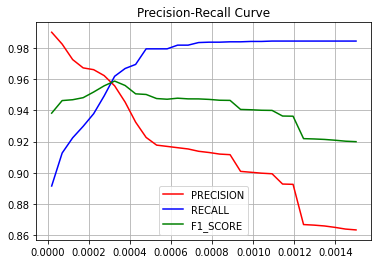

In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score

# Plot the output.
plt.plot(thresh, precision, c ='r', label ='PRECISION')
plt.plot(thresh, recall, c ='b', label ='RECALL')
plt.plot(thresh, f1_score, c ='g', label ='F1_SCORE')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')

In [55]:
testkeys = list(data_test.keys())
testkeys
helyes_test_eredmeny = []
for i in testkeys:
    a = helyes_eredmeny[int(i)]
    helyes_test_eredmeny.append(a)
#print(list(data_test.keys()))
len(helyes_test_eredmeny)

143751

In [56]:
##scaler = MinMaxScaler()
##training_data = scaler.fit_transform(training_data)
X_test = []
y_test = []

list_temp = [] 
maxlen = 0
MaxWindow = 50

values = list(data_test.values())

for i in tqdm(range(0, len(data_test.keys()))):
    first_value = values[i] #Adott kulcsokhoz tartozó tömb
    if len(first_value) < MaxWindow: ## Ha kisebb mint a MaxWindow
        list_of_zeros = [0] * (MaxWindow - len(first_value)) # Zérusokat tartalmazó
        X_to_append = [len(every_EventId.keys()) + 1] + first_value + list_of_zeros # [49,1,1,1,2,3,0,0,0,0,0,0,0]
        X_test.append(X_to_append)
        
        Y_to_append = list(np.array(first_value, dtype="float")-1)
        Y_to_append.append(len(every_EventId.keys())) # END jel a végén
        Y_to_append += list_of_zeros
        y_test.append(Y_to_append)
    else:
        helyes_test_eredmeny.pop(i)

with open('X_test.txt', 'w') as g:
     g.write(json.dumps(X_test))
with open('y_test.txt', 'w') as gg:
     gg.write(json.dumps(y_test))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143751/143751 [00:02<00:00, 56181.87it/s]


In [57]:
len(helyes_test_eredmeny)

143740

In [58]:
len(X_test)

143740

In [59]:
X_test, y_test = np.array(X_test, dtype="int16"), np.array(y_test, dtype="int16")

In [60]:
y_new_pred = regressior.predict(X_test)

4492/4492 [==============================] - 26s 6ms/step


In [61]:
y_new_pred

array([[[7.4539667e-01, 2.5448528e-01, 3.4402634e-05, ...,
         5.4665200e-08, 5.6534226e-08, 1.3691994e-07],
        [7.2798193e-01, 2.7076188e-01, 1.2297132e-03, ...,
         1.3055636e-08, 1.0167856e-08, 5.1745083e-08],
        [6.6361010e-01, 3.3605787e-01, 2.9644321e-04, ...,
         3.5725607e-09, 2.1832336e-09, 7.5424094e-09],
        ...,
        [2.9781060e-02, 2.9057857e-02, 2.6309064e-02, ...,
         1.7535254e-02, 1.7066328e-02, 2.5845075e-02],
        [2.9781060e-02, 2.9057857e-02, 2.6309064e-02, ...,
         1.7535254e-02, 1.7066328e-02, 2.5845075e-02],
        [2.9781060e-02, 2.9057857e-02, 2.6309064e-02, ...,
         1.7535254e-02, 1.7066328e-02, 2.5845075e-02]],

       [[7.4539667e-01, 2.5448528e-01, 3.4402634e-05, ...,
         5.4665200e-08, 5.6534226e-08, 1.3691994e-07],
        [7.2798193e-01, 2.7076188e-01, 1.2297132e-03, ...,
         1.3055636e-08, 1.0167856e-08, 5.1745083e-08],
        [9.9959308e-01, 5.2349405e-06, 3.4932856e-04, ...,
         7.900

In [62]:
possib_test_array = []

for i in tqdm(range(0,len(y_new_pred))): #belső
    possib_test_array.append([])
    for j in range(0,len(y_new_pred[i])):
        if(y_test[i][j] != 0 and y_test[i][j] != 49): # Lehet ki kell venni
            possib_test_array[i].append(y_new_pred[i][j][y_test[i][j]])
#possib_array # Valószínűségek listája

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143740/143740 [00:15<00:00, 9362.06it/s]


In [63]:
len(possib_test_array)

143740

In [68]:
#thresh = np.linspace(0, 0.02,25) 
thresh = 0
accuracy = 0
precision =0
recall = 0
f1_score = 0

print('Threshold \t\t Accuracy \t\t Precision \t\t Recall \t\t  F1 Score ')

prediction = a_simple_classifier(possib_test_array, max_threshold)
accuracy, precision, recall, f1_score = calculate_metrics(prediction, helyes_test_eredmeny)
print(f'{max_threshold: .7f}\t\t {accuracy: .7f}\t\t {precision: .7f}\t\t {recall: .7f}\t\t {f1_score: .7f}')

Threshold 		 Accuracy 		 Precision 		 Recall 		  F1 Score 
 0.0003262		  0.9974816		  0.9557416		  0.9575743		  0.9566571
